In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import cm
import matplotlib as mpl    
import seaborn as sns

mpl.rc('font',family='serif')

import pickle

from sklearn.metrics import f1_score, average_precision_score, brier_score_loss, roc_auc_score

In [2]:
# pkl_file = open('xgboost_dict_of_dicts.pkl', 'rb')
# dict_of_dicts = pickle.load(pkl_file)
# pkl_file.close()

pkl_file = open('new_test_df.pkl', 'rb')
df_test = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('new_train_df.pkl', 'rb')
df_train = pickle.load(pkl_file)
pkl_file.close()

df_test['binary_best'] = (df_test['best']>0)+0
df_train['binary_best']  = (df_train['best']>0)+0

pkl_file = open('xgboost_dict_of_dicts_new.pkl', 'rb')
dict_of_dicts = pickle.load(pkl_file)
pkl_file.close()

/home/polichinel/anaconda3/envs/geo_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# Robustness v. 3 baselines:
- last obs
- conflict ratio
- cm_mean

In [3]:
def logit(z):
    a = 1/(1+np.exp(-z))
    
    return(a)

def baysian_correction(a):
    
    ones = df_train['binary_best'].sum()/df_train['binary_best'].shape[0]
    zeroes = 1 - (df_train['binary_best'].sum()/df_train['binary_best'].shape[0])
    
    y_hat =  (a*ones)/((a*ones)+((1-a)*zeroes))
    return(y_hat)

In [4]:
def get_baselines():
    
    # true y:
    y = df_test[['binary_best','year']]
    
    # baseline last obs
    baseline_lastObs = df_train[df_train['year']==2012]['binary_best']
    baseline_lastObs.name = 'baseline_lastObs'

    # baseline conflcit ratio
    baseline_ratio = df_train.groupby('gid').mean()['binary_best']
    baseline_ratio.name = 'baseline_ratio'
    
    # baseline cm
    cm_mu = df_test['cm_mu']
    logit_cm_mu = logit(cm_mu)
    bayes_cm_mu = baysian_correction(logit_cm_mu)
    baseline_cm = pd.DataFrame([bayes_cm_mu,df_test['year']]).T
    baseline_cm.columns = ['baseline_cm','year']
    
    return(y, baseline_lastObs, baseline_ratio, baseline_cm)

In [5]:
y, baseline_lastObs, baseline_ratio, baseline_cm = get_baselines()

In [6]:
def get_metrics(y, baseline_lastObs, baseline_ratio, baseline_cm, threshold = 0.1):
    
    lastObs_f1 = []
    ratio_f1 = []
    cm_f1 = []
    full_f1 = []
    
    lastObs_ap = []
    ratio_ap = []
    cm_ap = []
    full_ap = []
    
    lastObs_brier = []
    ratio_brier = []
    cm_brier = []
    full_brier = []
    
    lastObs_auc = []
    ratio_auc = []
    cm_auc = []
    full_auc = []
    
    years = df_test['year'].unique()
    
    y_hat_lastObs = baseline_lastObs
    y_hat_ratio = baseline_ratio

    for i in years:
        y_true = y[y['year'] == i]['binary_best']
        
        y_hat_cm = baseline_cm[baseline_cm['year']==i]['baseline_cm']
#         y_hat_full = baseline_full[baseline_full['year']==i]['baseline_full']
        y_hat_full = np.array(dict_of_dicts[str(i)]['preds_bayes']).mean(axis = 0)

        
        lastObs_f1.append(f1_score(y_true, y_hat_lastObs))
        ratio_f1.append(f1_score(y_true, (y_hat_ratio>=threshold)))
        cm_f1.append(f1_score(y_true, y_hat_cm>=threshold))
        full_f1.append(f1_score(y_true, y_hat_full>=threshold))
                              
        lastObs_ap.append(average_precision_score(y_true, y_hat_lastObs))
        ratio_ap.append(average_precision_score(y_true, y_hat_ratio))
        cm_ap.append(average_precision_score(y_true, y_hat_cm))            
        full_ap.append(average_precision_score(y_true, y_hat_full))
                              
        lastObs_brier.append(brier_score_loss(y_true, y_hat_lastObs))
        ratio_brier.append(brier_score_loss(y_true, y_hat_ratio))
        cm_brier.append(brier_score_loss(y_true, y_hat_cm))                   
        full_brier.append(brier_score_loss(y_true, y_hat_full))

        lastObs_auc.append(roc_auc_score(y_true, y_hat_lastObs))
        ratio_auc.append(roc_auc_score(y_true, y_hat_ratio))
        cm_auc.append(roc_auc_score(y_true, y_hat_cm))                   
        full_auc.append(roc_auc_score(y_true, y_hat_full))
        
                                 
    f1_dict = {'lastObs_f1' : lastObs_f1, 'ratio_f1': ratio_f1, 'cm_f1' : cm_f1, 'full_f1' : full_f1}
    ap_dict = {'lastObs_ap' : lastObs_ap, 'ratio_ap' : ratio_ap, 'cm_ap' : cm_ap, 'full_ap' : full_ap}
    brier_dict = {'lastObs_brier' : lastObs_brier, 'ratio_brier' : ratio_brier, 'cm_brier' : cm_brier, 'full_brier' : full_brier}
    auc_dict = {'lastObs_auc' : lastObs_auc, 'ratio_auc' : ratio_auc, 'cm_auc' : cm_auc, 'full_auc' : full_auc}

    
    return(f1_dict, ap_dict, brier_dict, auc_dict)

In [7]:
f1_dict, ap_dict, brier_dict, auc_dict = get_metrics(y, baseline_lastObs, baseline_ratio, baseline_cm)

Somehow your full model does slightly better through this framwork compered to script with models.. How? maybe a change in sklearn? Better Baysian correction? Should you run all your models again?

In [8]:
def baseline_brier():
    years = df_test['year'].unique()

    plt.figure(figsize=[15,5])

    plt.plot(years, brier_dict['lastObs_brier'], 'o-', label = 'lastObs_brier')
    plt.plot(years, brier_dict['ratio_brier'], 'o-', label = 'ratio_brier')
    plt.plot(years, brier_dict['cm_brier'], 'o-', label = 'cm_brier')
    plt.plot(years, brier_dict['full_brier'], 'o-', label = 'full_brier')


    plt.legend()

    plt.grid()
    sns.despine()
    plt.show()

In [9]:
def baseline_ap():
    years = df_test['year'].unique()

    plt.figure(figsize=[15,5])

    plt.plot(years, ap_dict['lastObs_ap'], 'o-', label = 'lastObs_ap')
    plt.plot(years, ap_dict['ratio_ap'], 'o-', label = 'ratio_ap')
    plt.plot(years, ap_dict['cm_ap'], 'o-', label = 'cm_ap')
    plt.plot(years, ap_dict['full_ap'], 'o-', label = 'full_ap')


    plt.legend()

    plt.grid()
    sns.despine()
    plt.show()

In [10]:
def baseline_auc():
    years = df_test['year'].unique()

    plt.figure(figsize=[15,5])

    plt.plot(years, auc_dict['lastObs_auc'], 'o-', label = 'lastObs_AUC')
    plt.plot(years, auc_dict['ratio_auc'], 'o-', label = 'ratio_AUC')
    plt.plot(years, auc_dict['cm_auc'], 'o-', label = 'cm_AUC')
    plt.plot(years, auc_dict['full_auc'], 'o-', label = 'full_AUC')


    plt.legend()

    plt.grid()
    sns.despine()
    plt.show()

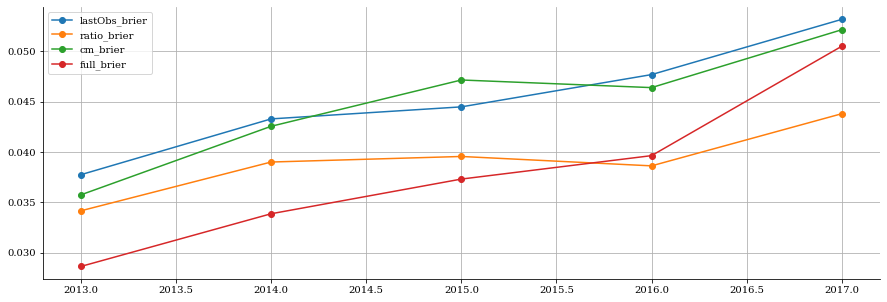

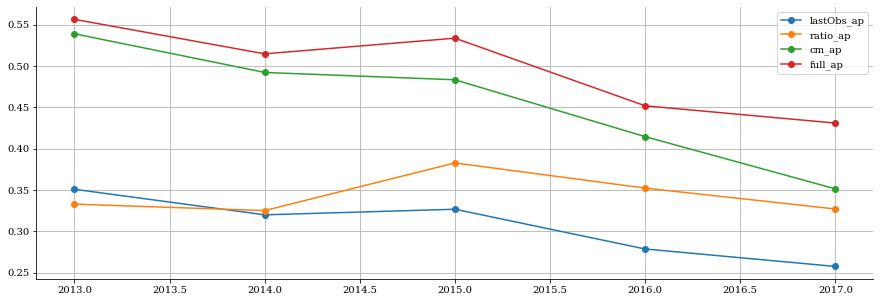

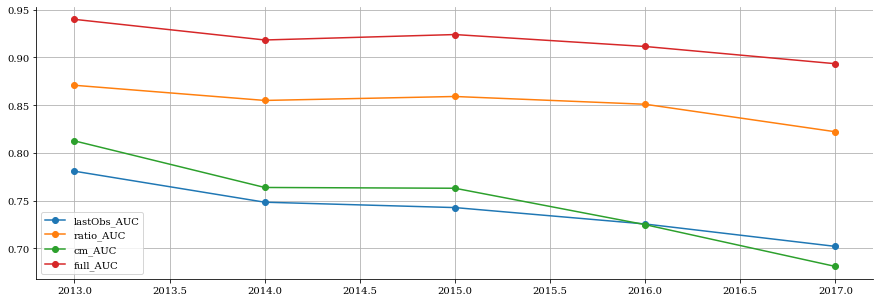

In [11]:
baseline_brier()
baseline_ap()
baseline_auc()

### looks fine. Put in conf, and then ONWARDS!!

Well, the "last obs" is a bit wierd for measures brier, auc or ap, but it is predictions. just only 100% and 0% predictions. Wich is also all we get from the knowledge from last year. Else you should use an exponetialle wieghted average, but you would have to come up with ${\beta}$, and that is exactly the point: you don't want to.
... That being said.. Now you have ${\ell}$ maybe it could be used as a proxy if you need to do something very fast? idk.

# old and working
Merge with above

## Yearly dist

In [12]:
def ap_score(fig_title):

    plt.figure(figsize=[13,5])

    test_years = np.arange(2013,2018,1)
    colors = sns.color_palette("hls", test_years.shape[0])
    # colors = sns.hls_palette(8, l=.5, s=.5)

    for i, j in enumerate(test_years):
        point_est = np.mean(dict_of_dicts[str(j)]['ap'])

        plot = sns.kdeplot(dict_of_dicts[str(j)]['ap'], 
                           color = colors[i], label = f'{j}')# point est.: {round(point_est,2)}')

        x, y = plot.lines[i].get_data()        
        plt.vlines(point_est, max(y) - 3, max(y) + 3, color = colors[i])
        plt.annotate(f'{round(point_est,2)}', (point_est+0.002, max(y)),
                     color = colors[i], fontsize = 14)

    plt.ylim(0,55)
    plt.xlim(0.35,0.60)
    plt.xticks(fontsize = 12)
    plt.yticks([], fontsize = 12)

    plt.legend(loc=2, fontsize = 14)
    plt.title('Average precision scores\n(out-of-sample)', fontsize = 16)
    plt.xlabel('AP', fontsize = 14)

    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

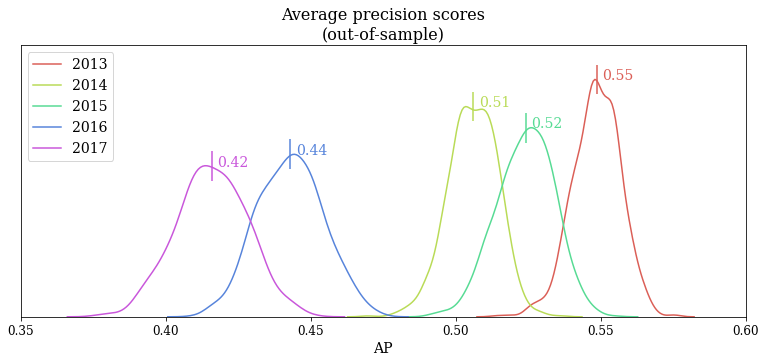

In [13]:
ap_score('ap_scores.pdf')

In [14]:
sum(np.array(dict_of_dicts['2014']['ap']) <= np.array(dict_of_dicts['2016']['ap']))/1000

0.0

In [15]:
sum(np.array(dict_of_dicts['2015']['ap']) <= np.array(dict_of_dicts['2016']['ap']))/1000

0.0

In [16]:
sum(np.array(dict_of_dicts['2015']['ap']) >= np.array(dict_of_dicts['2013']['ap']))/1000

0.024

In [17]:
sum(np.array(dict_of_dicts['2015']['ap']) >= np.array(dict_of_dicts['2014']['ap']))/1000

0.893

In [24]:
def auc_score(fig_title):

    plt.figure(figsize=[13,5])

    test_years = np.arange(2013,2018,1)
    colors = sns.color_palette("hls", test_years.shape[0])
    # colors = sns.hls_palette(8, l=.5, s=.5)

    for i, j in enumerate(test_years):
        point_est = np.mean(dict_of_dicts[str(j)]['auc'])

        plot = sns.kdeplot(dict_of_dicts[str(j)]['auc'], 
                           color = colors[i], label = f'{j}')# point est.: {round(point_est,2)}')

        x, y = plot.lines[i].get_data()        
        plt.vlines(point_est, max(y) - 3, max(y) + 3, color = colors[i])
        plt.annotate(f'{round(point_est,2)}', (point_est+0.002, max(y)),
                     color = colors[i], fontsize = 14)

#     plt.ylim(0,55)
#     plt.xlim(0.35,0.60)
    plt.xticks(fontsize = 12)
    plt.yticks([], fontsize = 12)

    plt.legend(loc=2, fontsize = 14)
    plt.title('Area Under the Curve scores\n(out-of-sample)', fontsize = 16)
    plt.xlabel('AUC', fontsize = 14)

    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

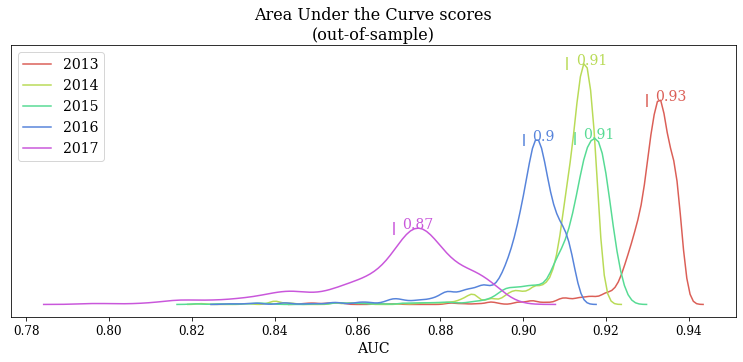

In [25]:
auc_score('auc_scores.pdf')

# Trendlines:

## AP

In [18]:
def ap_trend(fig_title):

    colors = sns.color_palette("hls", 3)
    
    ap_means = []
    ap_highs = []
    ap_lows = []
    years = []

    for i in np.arange(2013,2018,1):
        ap_means.append(dict_of_dicts[str(i)]['mean_ap'])
        ap_highs.append(dict_of_dicts[str(i)]['high_ap'])
        ap_lows.append(dict_of_dicts[str(i)]['low_ap'])

        years.append(i)


    plt.figure(figsize=[13,5])

    plt.plot(years,ap_means, '-o', color = 'C1', label  = 'full_ap')
    plt.fill_between(years, ap_highs, ap_lows, color = 'navajowhite', alpha = 0.5, label  = '99% credibility interval')

    plt.vlines(2012+3,0,0.6,color='darksalmon', linestyle='dashed',alpha = 0.8)

    #-------------------------------------------------------------------------
    

    plt.plot(years, ap_dict['lastObs_ap'], 'o-', color = colors[0], label = 'lastObs_ap')
    plt.plot(years, ap_dict['ratio_ap'], 'o-', color = colors[1], label = 'ratio_ap')
    plt.plot(years, ap_dict['cm_ap'], 'o-', color = colors[2], label = 'cm_ap')
#     plt.plot(years, ap_dict['full_ap'], 'o-', label = 'full_ap')
    
    #-------------------------------------------------------------------------
    
    plt.legend(loc = 3,frameon = False, fontsize = 14)
    
    plt.xticks(years)

    plt.xlim(2013,2017)
    plt.ylim(0.1,0.6)

    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

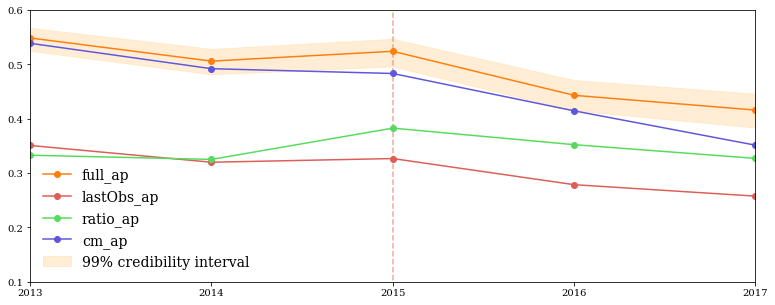

In [19]:
ap_trend('ap_trend_basline.pdf')

In [20]:
def ap_trend_alt(fig_title):

    years = list(dict_of_dicts.keys())
    ap_means = []
    plt.figure(figsize=[13,5])


    for i in np.arange(0,1000,1):
        list_of_ap = [] 
        for year in years:
            list_of_ap.append(dict_of_dicts[year]['ap'][i])

        plt.plot(years, list_of_ap, color='C0', alpha=0.01)

    for i in np.arange(2013,2018,1):
        ap_means.append(dict_of_dicts[str(i)]['mean_ap'])

    plt.plot(years, ap_means, '-o', color = 'C1')
    
    plt.vlines(years[2],0,0.6,color='darksalmon', linestyle='dashed',alpha = 0.8)

    
    #-------------------------------------------------------------------------
    
    plt.plot(years, ap_dict['cm_ap'], 'o-', color='firebrick')
    plt.plot(years, ap_dict['lastObs_ap'], 'o-', color='teal')
    plt.plot(years, ap_dict['ratio_ap'], 'o-', color='slateblue')
#     plt.plot(years, ap_dict['full_ap'], 'o-', label = 'full_ap', color='c')# Why is this slightly better?
    
    #-------------------------------------------------------------------------
    
    cred_label = "Full model, 1000 samples"
    mean_label = 'Full model, point estimat'
    cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=10, label=cred_label)
    mean_line = mlines.Line2D([], [], color='C1', marker='o', markersize=10, label=mean_label)
    

        
    cm_label = "$σ(f_{cm}(\cdot))$"
    lastObs_label = '$y_{2012}$'
    ratio_label = 'Conflict ratio (1989-2012)'
    cm_line = mlines.Line2D([], [], color='firebrick', marker='o', markersize=10, label=cm_label)
    lastObs_line = mlines.Line2D([], [], color='teal', marker='o', markersize=10, label=lastObs_label)
    ratio_line = mlines.Line2D([], [], color='slateblue', marker='o', markersize=10, label=ratio_label)
    
    vline_label= r'$ \approx 2012 + \ell$'
    vline_line = mlines.Line2D([], [], color='darksalmon', linestyle='--', markersize=10, label=vline_label)
    
    plt.legend(loc=8, handles=[mean_line, cred_line, vline_line, lastObs_line, ratio_line, cm_line],frameon = False, fontsize = 14, ncol = 2)
    


    plt.title('Average Precision trend\nFull model vs. 3 baselines (out-of-sample)', fontsize = 16)
    plt.xlabel('years', fontsize = 14)
    plt.ylabel('AP', fontsize = 14)
    
    plt.xlim(years[0],years[-1])
    plt.ylim(0.15,0.6)

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
    plt.savefig(fig_title, bbox_inches="tight")
    

    plt.show()

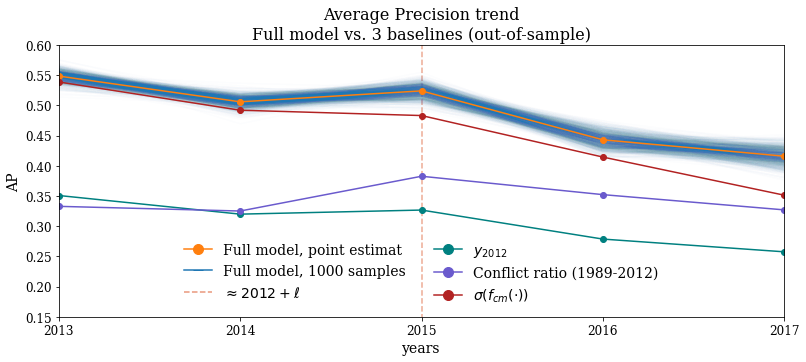

In [21]:
ap_trend_alt('ap_trend_alt_baseline.pdf')

In [22]:
df_test[df_test['year']==2014]['binary_best'].sum()/df_test[df_test['year']==2014]['binary_best'].shape

array([0.04979095])

In [23]:
df_test[df_test['year']==2015]['binary_best'].sum()/df_test[df_test['year']==2015]['binary_best'].shape

array([0.05304881])

## AUC

In [24]:
def auc_trend_alt(fig_title):

    years = list(dict_of_dicts.keys())
    auc_means = []
    plt.figure(figsize=[13,5])


    for i in np.arange(0,1000,1):
        list_of_auc = [] 
        for year in years:
            list_of_auc.append(dict_of_dicts[year]['auc'][i])

        plt.plot(years, list_of_auc, color='C0', alpha=0.01)

    for i in np.arange(2013,2018,1):
        auc_means.append(np.mean(dict_of_dicts[str(i)]['auc']))

    plt.plot(years, auc_means, '-o', color = 'C1')
    
    plt.vlines(years[2],0,1,color='darksalmon', linestyle='dashed',alpha = 0.8)

    
    #-------------------------------------------------------------------------
    
    plt.plot(years, auc_dict['cm_auc'], 'o-', color='firebrick')
    plt.plot(years, auc_dict['lastObs_auc'], 'o-', color='teal')
    plt.plot(years, auc_dict['ratio_auc'], 'o-', color='slateblue')
#     plt.plot(years, auc_dict['full_auc'], 'o-', color='c')# why is this slightly better?
    
    #-------------------------------------------------------------------------
    
    cred_label = "Full model, 1000 samples"
    mean_label = 'Full model, point estimat'
    cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=10, label=cred_label)
    mean_line = mlines.Line2D([], [], color='C1', marker='o', markersize=10, label=mean_label)
    
        
    cm_label = "$σ(f_{cm}(\cdot))$"
    lastObs_label = '$y_{2012}$'
    ratio_label = 'Conflict ratio (1989-2012)'
    cm_line = mlines.Line2D([], [], color='firebrick', marker='o', markersize=10, label=cm_label)
    lastObs_line = mlines.Line2D([], [], color='teal', marker='o', markersize=10, label=lastObs_label)
    ratio_line = mlines.Line2D([], [], color='slateblue', marker='o', markersize=10, label=ratio_label)
    
    vline_label= r'$ \approx 2012 + \ell$'
    vline_line = mlines.Line2D([], [], color='darksalmon', linestyle='--', markersize=10, label=vline_label)
    
    plt.legend(loc=8, handles=[mean_line, cred_line, vline_line, lastObs_line, ratio_line, cm_line],frameon = False, fontsize = 14, ncol = 2)
    


    plt.title('Area Under the Curve trend\nFull model vs. 3 baselines (out-of-sample)', fontsize = 16)
    plt.xlabel('years', fontsize = 14)
    plt.ylabel('AUC', fontsize = 14)
    
    plt.xlim(years[0],years[-1])
    plt.ylim(0.6,1)

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
    plt.savefig(fig_title, bbox_inches="tight")
    

    plt.show()

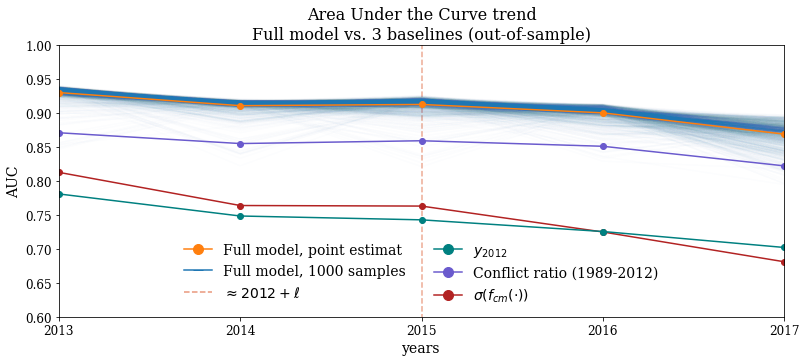

In [25]:
auc_trend_alt('auc_trend_alt_baseline.pdf')

# Curves

In [26]:
def pr_curve(fig_title, year):
    
    baseline = df_test[df_test['year']==year]['binary_best'].sum()/df_test[df_test['year']==year]['binary_best'].shape
    
    dict_of_metrics = dict_of_dicts[str(year)]

    plt.figure(figsize=[9,9])

    for i in np.arange(0,1000,1):
        plt.plot(dict_of_metrics['recall'][i], dict_of_metrics['precision'][i], color='C0', alpha=0.01)

    mean_ap = dict_of_metrics['mean_ap']
    high_ap = dict_of_metrics['high_ap']
    low_ap = dict_of_metrics['low_ap']

    plt.plot(dict_of_metrics['recall_mean'], dict_of_metrics['precision_mean'], color='C1', alpha=1)
    plt.hlines(baseline, 0, 1, color='gray', linestyle='--')

    
    plt.title(f'Precision-Recall Curve {year}', fontsize = 16)
    
    plt.xlabel('Recall', fontsize = 14)
    plt.ylabel('Precision', fontsize = 14)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])

    sns.despine()

    cred_label = "Average precision 99% credibility interval: " + str(low_ap.round(3)) + '-' + str(high_ap.round(2))
    mean_label = 'Average precision point estimat (mean): ' + str(mean_ap.round(3))
    random_label = '"Random" baseline'

    cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=15, label=cred_label)

    mean_line = mlines.Line2D([], [], color='C1', marker='_', markersize=15, label=mean_label)
    
    random_line = mlines.Line2D([], [], color='gray', linestyle='--', markersize=15, label=random_label)

    plt.legend(handles=[mean_line, cred_line, random_line],frameon = False, fontsize = 14)

    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()


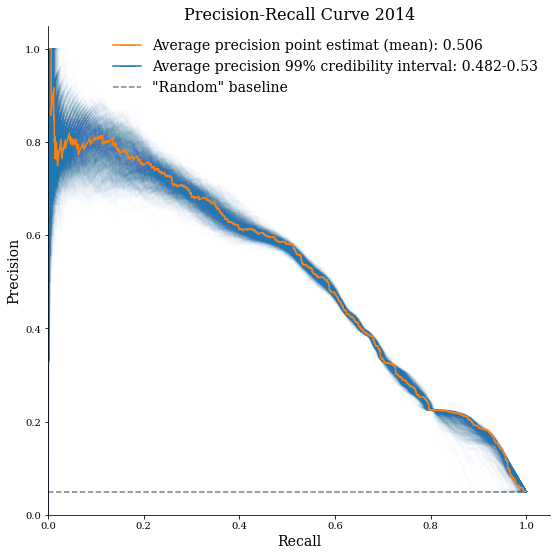

In [27]:
pr_curve('PR_2014_new.pdf', 2014)

In [28]:
# years  = [2014,2015]

def pr_curves(fig_title, years):

    fig, axes = plt.subplots(1, len(years), sharey=False,figsize=(13,5))

    for i, j in enumerate(years):
        baseline = df_test[df_test['year']==j]['binary_best'].sum()/df_test[df_test['year']==j]['binary_best'].shape

        dict_of_metrics = dict_of_dicts[str(j)]  
        mean_ap = dict_of_metrics['mean_ap']
        high_ap = dict_of_metrics['high_ap']
        low_ap = dict_of_metrics['low_ap']

    #     mean_auc =  np.mean(dict_of_metrics['auc'])
    #     high_auc = np.percentile(np.array(dict_of_metrics['auc']),97.5)
    #     low_auc = np.percentile(np.array(dict_of_metrics['auc']),2.5)


        for n in np.arange(0,1000,1):
            axes[i].plot(dict_of_metrics['recall'][n], dict_of_metrics['precision'][n], color='C0', alpha=0.01)

        axes[i].plot(dict_of_metrics['recall_mean'], dict_of_metrics['precision_mean'], color='C1', alpha=1)
        axes[i].hlines(baseline, 0, 1, color='gray', linestyle='--')
        axes[i].set_title(f'{j}', fontsize = 14)

        cred_label = f'AP 99% cred. int.: {low_ap.round(2)} - {high_ap.round(2)}'
        mean_label = f'AP point est.: {mean_ap.round(2)}'
        random_label = '"Random" baseline'

        cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=15, label=cred_label)
        mean_line = mlines.Line2D([], [], color='C1', marker='_', markersize=15, label=mean_label)
        random_line = mlines.Line2D([], [], color='gray',linestyle='--', markersize=15, label=random_label)


        axes[i].legend(handles=[mean_line, cred_line, random_line], frameon = False, fontsize = 14, loc = 1)

    #     auc_text = f'ROC-AUC point est.: {mean_auc.round(2)}\nROC-AUC 99% credibility int.: {low_auc.round(2)} - {high_auc.round(2)}'

    #     axes[i].annotate(auc_text,(0.05,0.1), fontsize = 14)

        axes[i].set_xlabel('Recall', fontsize = 14)
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlim([0.0, 1.05])
        
        axes[i].set_xticklabels(np.arange(0,1.1,0.2).round(1),fontsize=12)


        if i == 0:
            axes[i].set_ylabel('Precision', fontsize = 14)
            axes[i].set_yticklabels(np.arange(0,1.1,0.2).round(1),fontsize=12)

            
        else:
            axes[i].set_ylabel('')
            axes[i].set_yticklabels([],fontsize=12)


    fig.suptitle('Precision-Recall Curves', fontsize = 16)    

    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

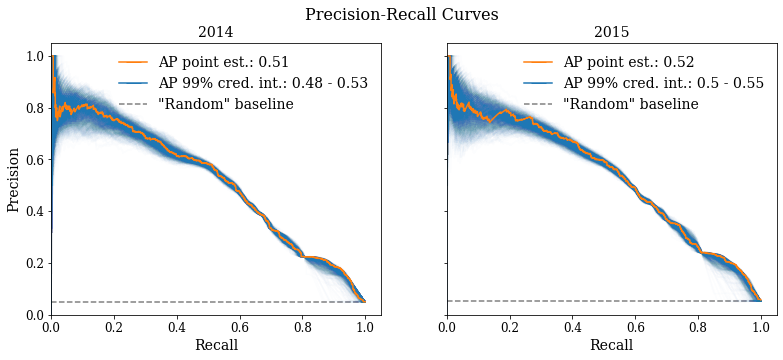

In [29]:
pr_curves('pr_curves_14_15_new.pdf', [2014,2015])

In [30]:
# pkl_file = open('xgboost_dict_of_dicts_new.pkl', 'rb')
# dict_of_dicts = pickle.load(pkl_file)
# pkl_file.close()

In [31]:
def roc_curves(fig_title, years):

    fig, axes = plt.subplots(1, len(years), sharey=False,figsize=(13,5))

    for i, j in enumerate(years):

        dict_of_metrics = dict_of_dicts[str(j)]  

        mean_auc = np.mean(dict_of_metrics['auc'])
        high_auc = np.percentile(np.array(dict_of_metrics['auc']),99.5)
        low_auc = np.percentile(np.array(dict_of_metrics['auc']),00.5) 

        for n in np.arange(0,1000,1): #1000
            axes[i].plot(dict_of_metrics['fpr'][n], dict_of_metrics['tpr'][n], color='C0', alpha=0.01)

        axes[i].plot(dict_of_metrics['fpr_mean'], dict_of_metrics['tpr_mean'], color='C1', alpha=1)
        axes[i].plot([0, 1], [0, 1], color='gray', linestyle='--')
        axes[i].set_title(f'{j}', fontsize = 14)

        cred_label = f'AUC 99% cred. int.: {low_auc.round(2)} - {high_auc.round(2)}'
        mean_label = f'AUC point est.: {mean_auc.round(2)}'
        random_label = '"Random" baseline'


        cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=15, label=cred_label)

        mean_line = mlines.Line2D([], [], color='C1', marker='_', markersize=15, label=mean_label)

        random_line = mlines.Line2D([], [], color='gray',linestyle='--', markersize=15, label=random_label)

        axes[i].legend(handles=[mean_line, cred_line, random_line], frameon = False, fontsize = 14, loc = 4)

    
    #     auc_text = f'ROC-AUC point est.: {mean_auc.round(2)}\nROC-AUC 99% credibility int.: {low_auc.round(2)} - {high_auc.round(2)}'

    #     axes[i].annotate(auc_text,(0.05,0.1), fontsize = 14)

        axes[i].set_xlabel('False positive rate', fontsize = 14)
        axes[i].set_ylim([0.0, 1.05])
        axes[i].set_xlim([0.0, 1.05])
        
        axes[i].set_xticklabels(np.arange(0,1.1,0.2).round(1),fontsize=12)


        if i == 0:
            axes[i].set_ylabel('True positive rate', fontsize = 14)
            axes[i].set_yticklabels(np.arange(0,1.1,0.2).round(1),fontsize=12)

            
        else:
            axes[i].set_ylabel('')
            axes[i].set_yticklabels([],fontsize=12)


    fig.suptitle('ROC Curves', fontsize = 16)    

    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

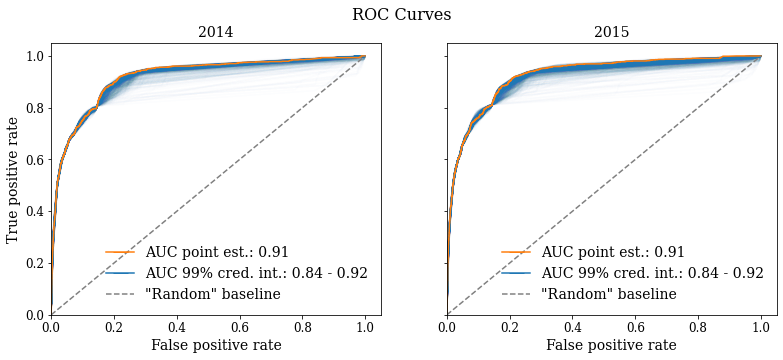

In [32]:
roc_curves('roc_curves_14_15_new.pdf', [2014,2015])

In [33]:
def prob_map(year):
    df_test_sub_ = df_test[df_test['year']==year].copy()
    df_test_sub_['predsB'] = dict_of_dicts[str(year)]['mean_preds']
    df_test_sub_.plot(column = 'predsB', figsize=[15,5], vmin = 0, vmax = 1, legend=True)
    
    # need predefined min, max and colorbar!
    
    plt.ylim(-10,50)
    plt.xlim(-20,100)
    plt.xlabel('longitude', fontsize = 14)
    plt.ylabel('latitude', fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
    plt.title(f'Estimated probabilities of conflict: {year}', fontsize = 16)
  
    fig_title = f'prop_map_{year}.pdf'
    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

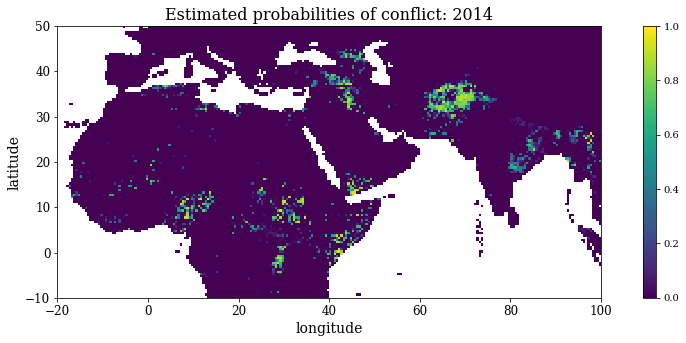

In [34]:
prob_map(2014)

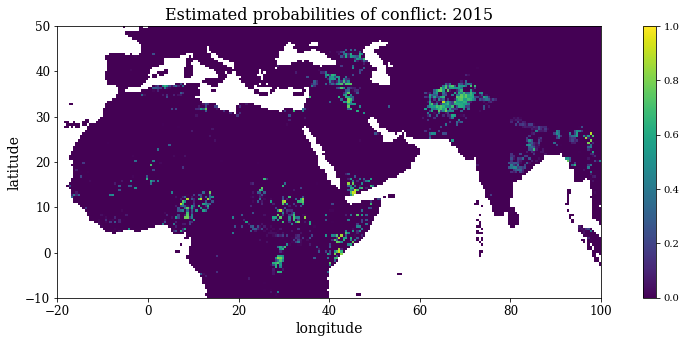

In [35]:
prob_map(2015)

In [47]:
def confusion_map(year, threshold):
    viridis = cm.get_cmap('viridis', 4)
    
    sub_df_test = df_test[df_test['year']==year].copy()
    sub_df_test['predsB'] = dict_of_dicts[str(year)]['mean_preds']

    binary_pred = (sub_df_test['predsB']>threshold)*1 # should be 0.15 to match posterior of 2012 (last observed year) distrbution with actually output
    sub_df_test['binary_pred'] =  binary_pred
    
    sub_df_test['TP'] = ((sub_df_test['binary_pred'] == 1) & (sub_df_test['binary_best'] == 1))*1
    sub_df_test['TN'] = ((sub_df_test['binary_pred'] == 0) & (sub_df_test['binary_best'] == 0))*1
    sub_df_test['FP'] = ((sub_df_test['binary_pred'] == 1) & (sub_df_test['binary_best'] == 0))*1
    sub_df_test['FN'] = ((sub_df_test['binary_pred'] == 0) & (sub_df_test['binary_best'] == 1))*1

    cats_list = ['TN','TP','FP','FN']

    plt.figure(figsize=[13.8,7])

#     colors = ['lightgrey','salmon','teal','crimson']
#     colors = ['lightsteelblue','indianred','steelblue','maroon']
#     colors = ['steelblue','maroon','lightsteelblue','indianred']

    colors = [viridis.colors[0],viridis.colors[3],viridis.colors[1],viridis.colors[2]]


    labels = ['true negatives', 'true positives', 'false positives', 'false negatives']

    for i, j in enumerate(cats_list):
        X = np.array([sub_df_test[sub_df_test[j]==1]['xcoord'], sub_df_test[sub_df_test[j]==1]['ycoord']]).T

        plt.scatter(X[:,0], X[:,1], s=9, c = colors[i], marker='s', label = labels[i])

    plt.ylim(-10,50)
    plt.xlim(-20,100)
    plt.xlabel('longitude', fontsize = 14)
    plt.ylabel('latitude', fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
        
    plt.title('Predictions {}\n Last year included i model: 2012\nThreshold: {}% probability of conflict'.format(year,threshold * 100)
              , fontsize = 16)
    plt.legend(fontsize = 14)

    fig_title = 'confusion_map_{}.pdf'.format(year)
    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()
    
    recall = sub_df_test['TP'].sum()/(sub_df_test['TP'].sum()+sub_df_test['FP'].sum())
    precision = sub_df_test['TP'].sum()/(sub_df_test['TP'].sum()+sub_df_test['FN'].sum())
    
    print(f'{year}\nrecall: {recall}\nprecision: {precision}')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

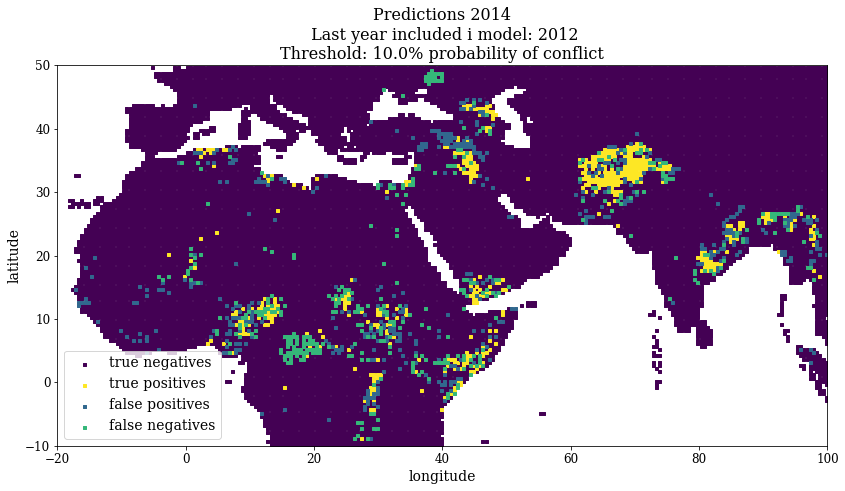

2014
recall: 0.5129224652087475
precision: 0.5627044711014176


In [48]:
confusion_map(2014,0.10)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

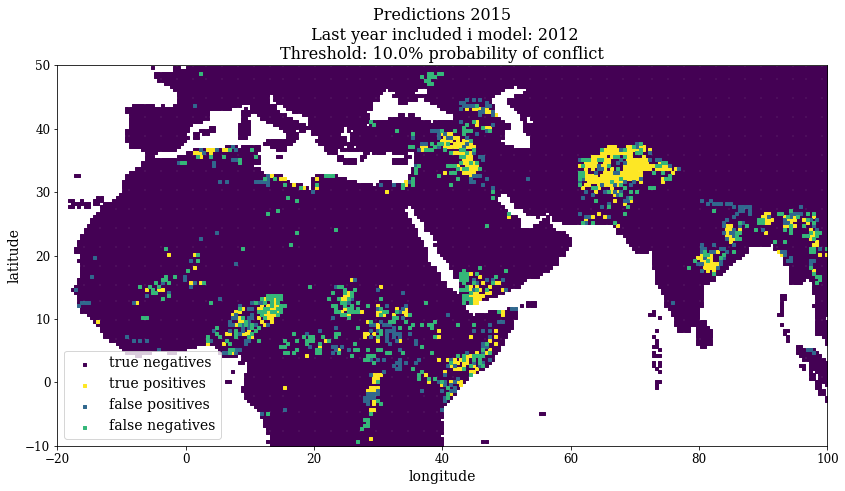

2015
recall: 0.5699888017917133
precision: 0.5209825997952917


In [49]:
confusion_map(2015,0.10)

In [80]:
def feature_imp(year):

    dict_of_metrics = dict_of_dicts[str(year)]  


    importances = np.array(dict_of_metrics['feature_imp']).mean(0)
    importances_std = np.array(dict_of_metrics['feature_imp']).std(0)


    indices = np.argsort(importances)[::-1]

    size = len(importances)

    plt.figure(figsize=[10,int(size)*0.75])

    plt.title("Feature importances" + f'\n({year})', fontsize = 16)


    plt.barh(range(size), importances[indices], color="salmon", align="center", yerr=importances_std[indices])

#     X_labels = ['dce_mu','cm_mu','dce_slope','cm_slope','dce_acc','cm_acc','cm_mass','dce_mass']
    X_labels = ["$f_{dce}$", "$f_{cm}$", "$f'_{dce}$", "$f'_{cm}$", "$f''_{dce}$", "$f''_{cm}$", "$F_{cm}$", "$F_{dce}$"]

    
    plt.yticks(range(size),  np.array(X_labels)[indices], fontsize = 14)
    plt.ylim([-1, size])

    plt.xlabel('gain', fontsize = 14)
    plt.ylabel('features', fontsize = 14)

    sns.despine()

    fig_title = f'feature_imp_{year}.pdf'
    plt.savefig(fig_title, bbox_inches="tight")

    plt.show()

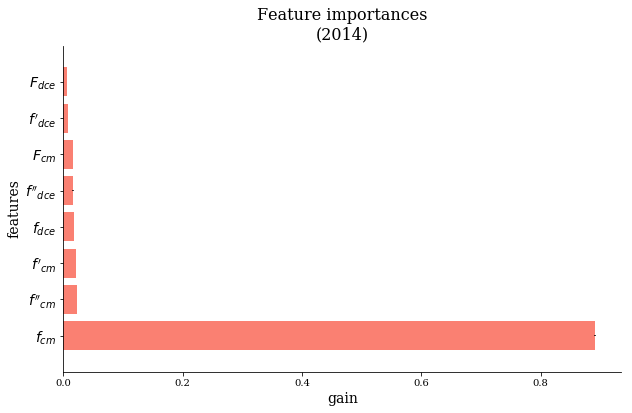

In [84]:
feature_imp(2014)

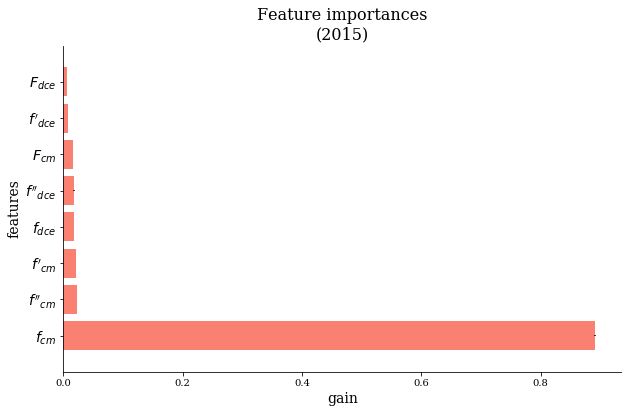

In [83]:
feature_imp(2015)

<Figure size 648x648 with 0 Axes>

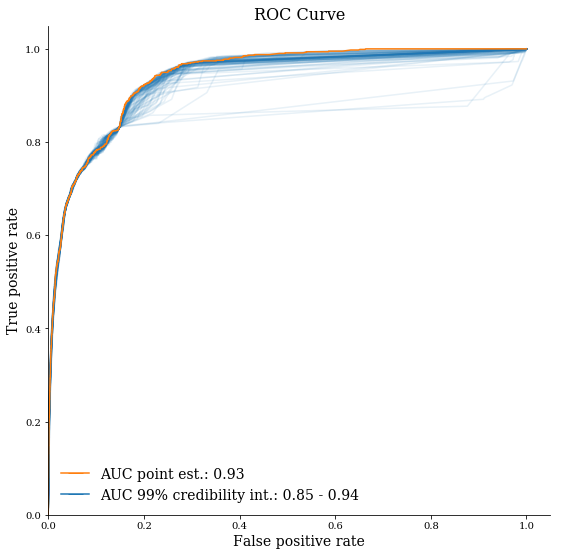

In [143]:
dict_of_metrics = dict_of_dicts['2013']

plt.figure(figsize=[9,9])

for i in np.arange(0,100,1):
    plt.plot(dict_of_metrics['fpr'][i], dict_of_metrics['tpr'][i], color='C0', alpha=0.1)

mean_auc = np.mean(dict_of_metrics['auc'])
high_auc = np.percentile(np.array(dict_of_metrics['auc']),99.5)
low_auc = np.percentile(np.array(dict_of_metrics['auc']),00.5) 
    
plt.plot(dict_of_metrics['fpr_mean'], dict_of_metrics['tpr_mean'], color='C1', alpha=1)

plt.title('ROC Curve', fontsize = 16)
    
plt.xlabel('False positive rate', fontsize = 14)
plt.ylabel('True positive rate', fontsize = 14)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])

sns.despine()


cred_label = f'AUC 99% credibility int.: {low_auc.round(2)} - {high_auc.round(2)}'
mean_label = f'AUC point est.: {mean_auc.round(2)}'

cred_line = mlines.Line2D([], [], color='C0', marker='_', markersize=15, label=cred_label)

mean_line = mlines.Line2D([], [], color='C1', marker='_', markersize=15, label=mean_label)

plt.legend(handles=[mean_line, cred_line],frameon = False, fontsize = 14)

plt.show()


In [69]:
np.mean(dict_of_metrics['auc'])
np.percentile(np.array(dict_of_metrics['auc']),97.5)
np.percentile(np.array(dict_of_metrics['auc']),2.5)

0.9130714806078802

In [97]:
dict_of_metrics.keys()

dict_keys(['auc', 'ap', 'recall', 'precision', 'preds1', 'preds0', 'preds_bayes', 'feature_imp', 'mean_ap', 'high_ap', 'low_ap', 'recall_mean', 'precision_mean', 'mean_preds'])

In [ ]:
np.array(dict_of_metrics['auc']).percentile

In [ ]:
np.array(dict_of_metrics['auc']).quantile